In [1]:
###############################################
## Import necessary libraries and files
###############################################
import numpy as cp
try:
    import cupy
    if cupy.cuda.is_available():
        cp = cupy
except:
    pass
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import time
import sys
from rbm import RBM
from aux import binarize_data
from aux import get_dataset
from aux import load_files
from aux import plot_funcs

In [2]:
###############################################
## Control Panel
###############################################

# hyperparameters of the RBM
model = ['mnist', 'hKH', 'lecun', 2e-3, 0.7, 100]

addrss = '' #'out/'
label = 'p1.5decay'
dataset = model[0]            #{'mnist','kmnist'} --dataset
KH = model[1]                 #{None, 'hKH', 'vKH', 'hvKH'} --KH Modulation approach
training = 'CD'               #{'CD', 'PCD'} --training algorithm of the RBM
k = 1                         # number of Gibbs sampling steps
epochs = 3                    # number of epochs (S)
W_init = model[2]             #{'lecun', 'std'} --weight initialization
eps0 = model[3]               # KH learning rate
eps_d = True                  #{False, True} -- decays with a polynomial eps0*(1- t/epochs)^(3/2)
delta = model[4]              # KH penalty term
seed = 1234                   # random seed
p = 2.0                       # KH Lebesgue power
l = 2                         # KH ranking parameter l >= 2
if W_init == 'std':
    R = 1.0                   # Lebesgue p norm radius
else:
    R = 0.1                   # Lebesgue p norm radius
batch_size = 100
eta = 1e-1                    # learning rate of the RBM
N = 784                       # number of visible units
M = model[5]                  # number of hidden units
incr = 1

###############################################
## Loading and preprocessing dataset
###############################################

train_data, valid_data, test_data, train_labels, valid_labels, test_labels = get_dataset(dataset=dataset)

try:
    if cp == cupy:
        train_data = cp.asarray(train_data)
        valid_data = cp.asarray(valid_data)
        test_data = cp.asarray(test_data)
except:
    pass

train_data = cp.concatenate((train_data,valid_data))

# data binarization
X_train = binarize_data(train_data)
X_test = binarize_data(test_data)

2024-09-10 15:22:16.081434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 15:22:17.937405: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-09-10 15:22:18.045550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-09-10 15:22:18.046013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start abo

Training Images Shape: (50000, 784)
Training Labels Shape: (50000, 10)
Validation Images Shape: (10000, 784)
Validation Labels Shape: (10000, 10)
Test Images Shape: (10000, 784)
Test Labels Shape: (10000, 10)


Epoch 1/3, Training Data Reconstructions:


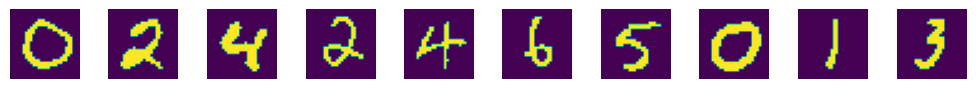

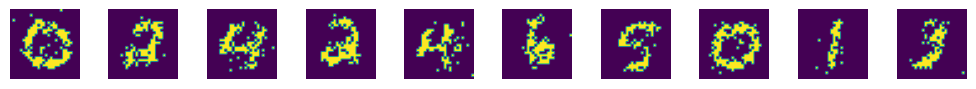

Epoch 1/3, Training MSE: 87.7771667
Epoch 1/3, Validation MSE: 69.4698000
Epoch 1/3, Validation Data Reconstructions:


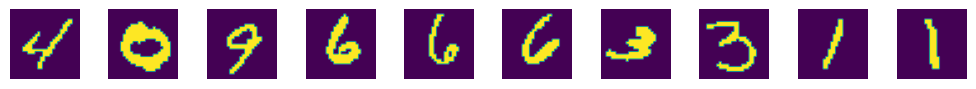

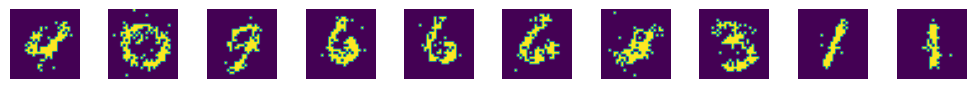

Receptive Fields:


<Figure size 640x480 with 0 Axes>

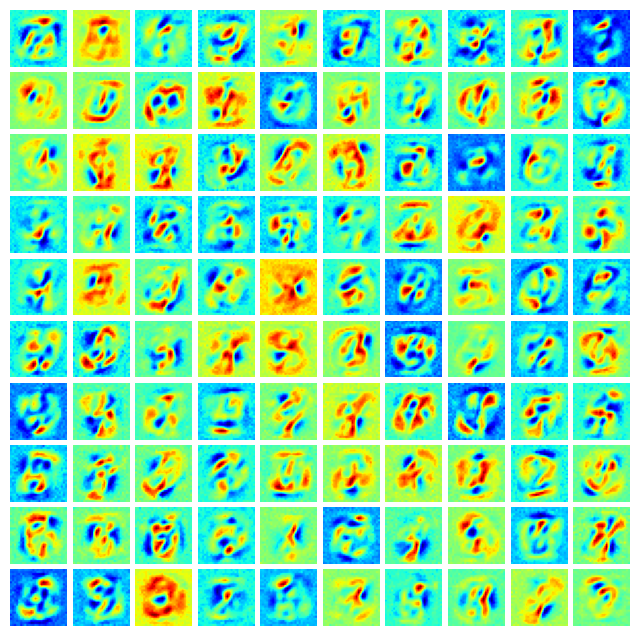

Epoch 2/3, Training Data Reconstructions:


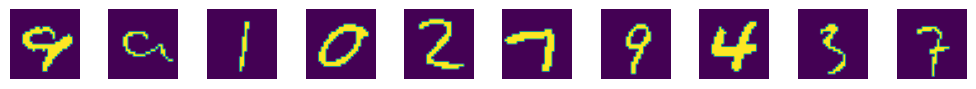

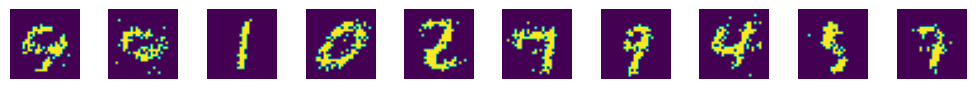

Epoch 2/3, Training MSE: 64.4416500
Epoch 2/3, Validation MSE: 60.9390000
Epoch 2/3, Validation Data Reconstructions:


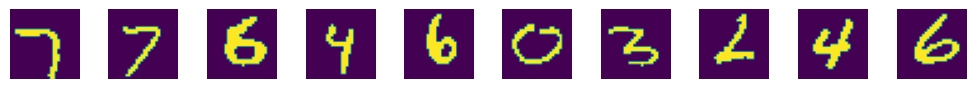

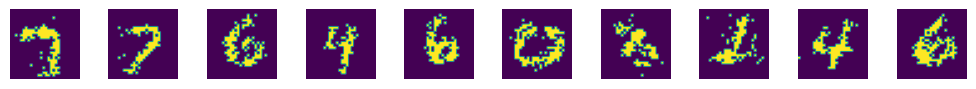

Receptive Fields:


<Figure size 640x480 with 0 Axes>

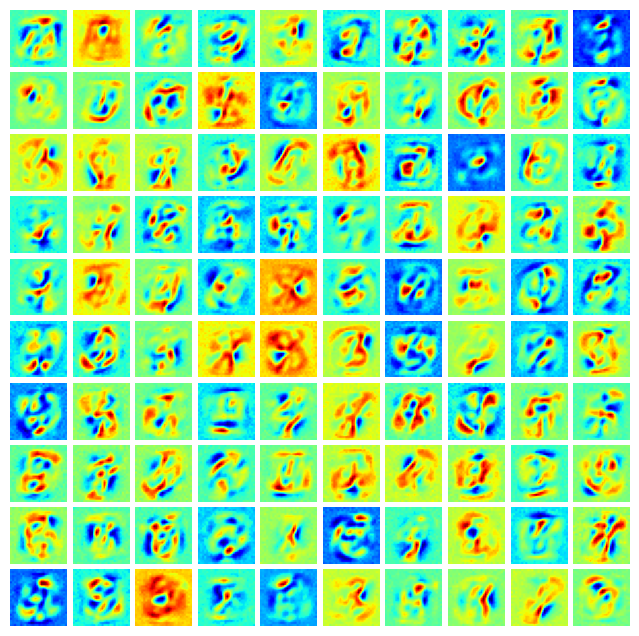

Epoch 3/3, Training Data Reconstructions:


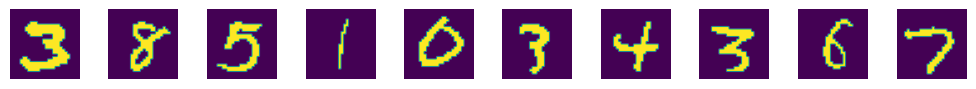

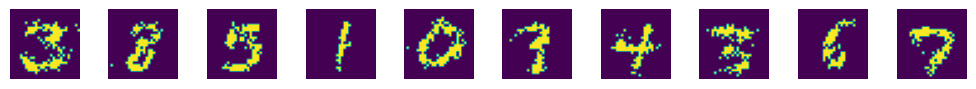

Epoch 3/3, Training MSE: 58.2192167
Epoch 3/3, Validation MSE: 56.4292000
Epoch 3/3, Validation Data Reconstructions:


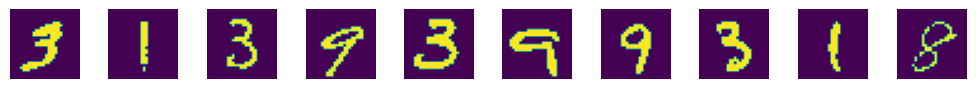

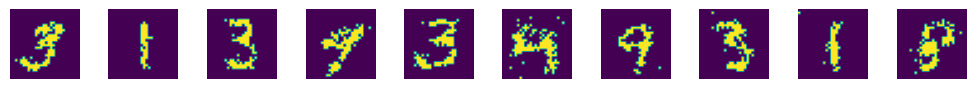

Receptive Fields:


<Figure size 640x480 with 0 Axes>

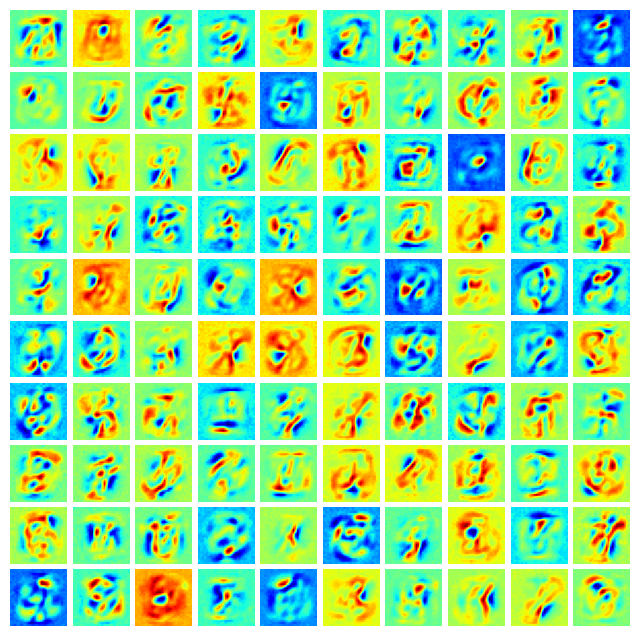

Total training time: 59.59 seconds


In [3]:
start_time = time.time()
cp.random.seed(seed)
rbm = RBM(N=N,M=M,eta=eta,batch_size=batch_size,W_init=W_init)
rbm.train(X_train,X_test, epochs=epochs,incr=incr, k=k,training=training,KH=KH,R=R,l=l,delta=delta, p=p,eps0=eps0,
          label=label,addrss=addrss,save_checkpoints=False,track_learning=True,save_learn_funcs=True,save_params=True,
          plot_weights=True,eps_d=eps_d,dataset=dataset,seed=seed)
end_time = time.time()  # Record the end time for the entire training process
total_training_time = end_time - start_time
print('Total training time: %.2f seconds' % total_training_time)

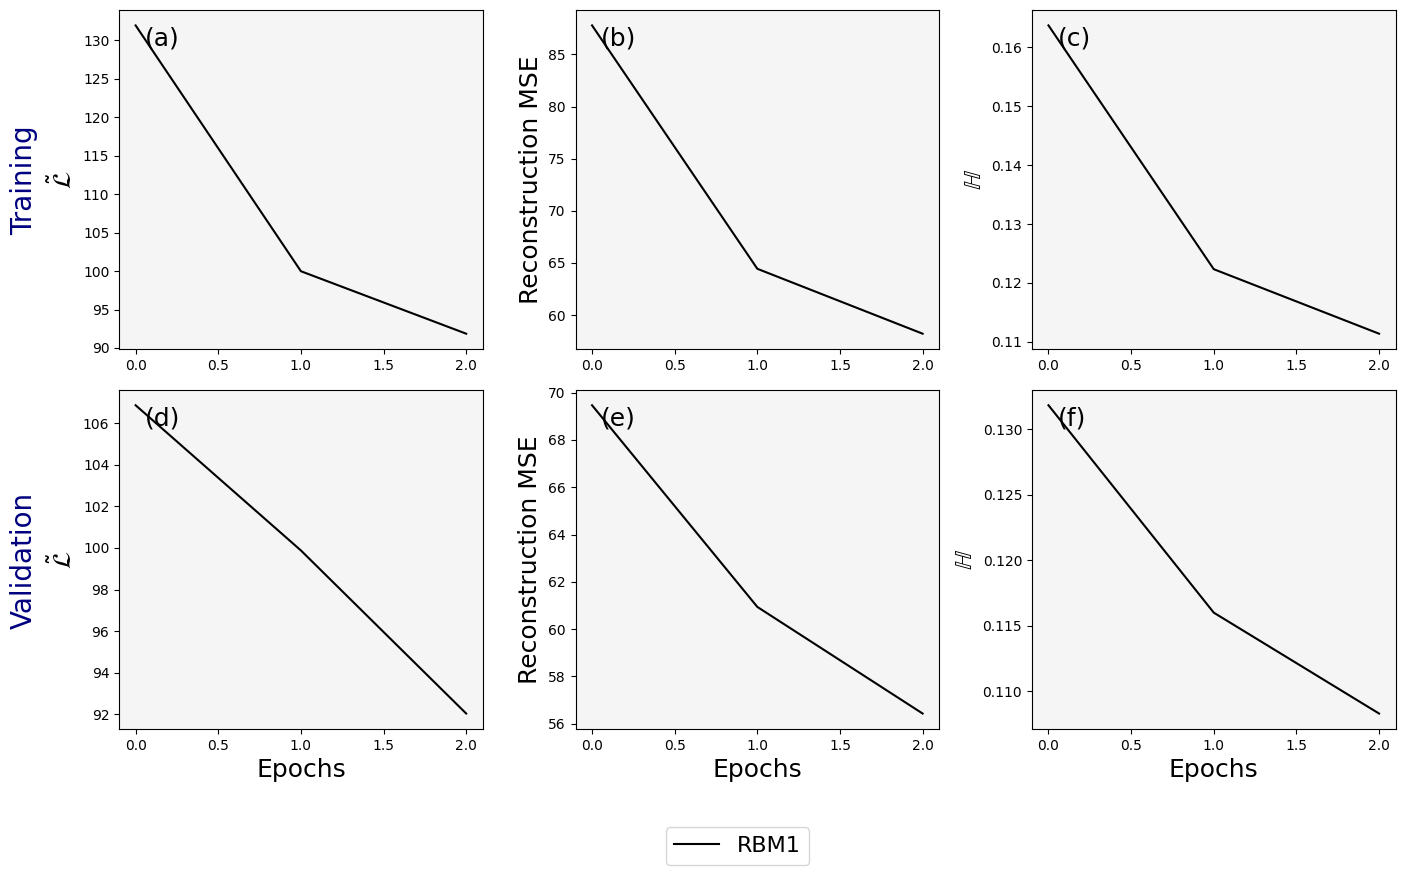

In [15]:
r_tr = load_files(d_name='_tr',training=training,k=k,M=M,eta=eta,KH=KH,l=l,delta=delta,p=p,eps0=eps0,label=label,addrss=addrss,
               epochs=epochs,batch_size=batch_size,R=R,W_init=W_init,eps_d=eps_d,dataset=dataset,seed=seed)
r_vl = load_files(d_name='_val',training=training,k=k,M=M,eta=eta,KH=KH,l=l,delta=delta,p=p,eps0=eps0,label=label,addrss=addrss,
               epochs=epochs,batch_size=batch_size,R=R,W_init=W_init,eps_d=eps_d,dataset=dataset,seed=seed)
r_tr = [r_tr]
r_vl = [r_vl]
limits = [[(200,501,140,160),(300,501,85,95),(300, 501, 0.168, 0.19)],
          [(300,501,155,174),(300,501,90,100),(300, 501, 0.182, 0.205)]]

inp_label = ['RBM1']
plot_funcs(r_tr,inp_label,r_vl,limits,sc='l',inset=False,save=False,name='')